<a href="https://colab.research.google.com/github/masdatascience/AI/blob/master/AI_TFM_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:


## Codificación de caracteristicas
#from sklearn import preprocessing


url = 'https://github.com/masdatascience/TFM-AI/blob/master/datos.xlsx?raw=true'
datos_modelo = pd.ExcelFile(url)
datos_facturacion = pd.read_excel(datos_modelo, sheet_name='fac_txn')
# Se elimian los datos nulos de las dimensiones importantes del analisis que son productos y clientes
datos_facturacion = datos_facturacion.dropna(subset=['customer_id'])
datos_facturacion = datos_facturacion.dropna(subset=['product_id'])
# Se elimina posibles chargeback que se presenten
datos_facturacion = datos_facturacion.loc[datos_facturacion['total_value'] > 0]
# Se descarcatan las ordenes que han sido canceladas
#datos_facturacion = datos_facturacion.loc[datos_facturacion['order_status'] != 'canceled']
print(datos_facturacion.shape)
datos_producto = pd.read_excel(datos_modelo, sheet_name='product')
datos_clientes = pd.read_excel(datos_modelo, sheet_name='customer')
print(datos_producto.shape)


## motor de recomendación

# Pivot table para la relación customer - producto
matrix_usuario_producto =pd.crosstab(datos_facturacion['customer_id'],datos_facturacion['product_id'],values=datos_facturacion['total_value'], aggfunc='sum', margins=True, margins_name="total_value")
print("datos cliente-producto: "+ str(matrix_usuario_producto.shape))
# Pivot table con la ifnormación normalizada 
matrix_usuario_producto_norm = (matrix_usuario_producto-matrix_usuario_producto.min())/(matrix_usuario_producto.max()-matrix_usuario_producto.min())
print("datos cliente-normalizado: "+ str(matrix_usuario_producto_norm.shape))
# Se crea una tabla como resultado de la normalización  
d = matrix_usuario_producto_norm.reset_index() 
d.index.names = ['value_freq'] 
data_norm = pd.melt(d, id_vars=['customer_id'], value_name='value_freq').dropna()
print("datos normalizados: "+ str(data_norm.shape))
# se integra información dummy
datos_dummy = datos_facturacion.copy()
datos_dummy['total_dummy'] = 1
print("datos dummy: "+ str(datos_dummy.shape))

# genero particionamiento de los conjuntos a usar
train_data, test_data  = train_test_split(datos_facturacion, test_size=0.2 ,random_state=1)
train_data_dummy, test_data_dummy = train_test_split(datos_dummy, test_size=0.2 ,random_state=1)
train_data_norm, test_data_norm = train_test_split(data_norm, test_size=0.2 ,random_state=1)


# Se define una función que retorne un modelo resultado segun el enfoque que se requiere:
# 1. Popularity : Es el item que más se a consumido en todos los clientes
# 2. cosine :
# 3. Pearson: 
def model(train_data, name, user_id, item_id, target, users_to_recommend, n_rec, n_display):
    if name == 'popularity':
        model = tc.popularity_recommender.create(train_data, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    target=target)
    elif name == 'cosine':
        model = tc.item_similarity_recommender.create(train_data, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    target=target, 
                                                    similarity_type='cosine')
    elif name == 'pearson':
        model = tc.item_similarity_recommender.create(train_data, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    target=target, 
                                                    similarity_type='pearson')
        
    recom = model.recommend(users=users_to_recommend, k=n_rec)
    recom.print_rows(n_display)
    return model
	
	
	
	# se definen parametros para recomendar el nu´meruo de productos a recomendar y una previsualziación definida del resultado
user_id = 'customer_id'
item_id = 'product_id'
users_to_recommend = list(datos_clientes[user_id])
n_rec = 5 # number of items to recommend
n_display = 15 # to display the first few rows in an output dataset



## Recomendador de productos

# más comprado
name = 'popularity'
target = 'total_value'
train_dataF=tc.SFrame(train_data)
test_dataF=tc.SFrame(test_data)
popularity_model = model(train_dataF, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

name = 'popularity'
target = 'total_dummy'
train_data_dummyF=tc.SFrame(train_data_dummy)
test_data_dummyF=tc.SFrame(test_data_dummy)
pop_dummy = model(train_data_dummyF, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

name = 'popularity'
target = 'value_freq'
train_data_normF=tc.SFrame(train_data_norm)
test_data_normF=tc.SFrame(test_data_norm)
pop_norm = model(test_data_normF, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

#Se identifica que el primer modelo genera los mismos valores ya es basado en la popularidad de todos los clientes y por ende es la misma recomendación para todos. De hecho si se agrupan los productos porel más vendido, se puede ver a continuación que tiene coherencia.

train_data.groupby(by='product_id')['total_value'].mean().sort_values(ascending=False).head()

## Colaborativo

# Cosine
name = 'cosine'
target = 'total_value'
cos = model(train_dataF, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)
target = 'total_dummy'
cos_dummy = model(train_data_dummyF, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)
target = 'value_freq'
cos_norm = model(train_data_normF, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)



# pearson 
name = 'pearson'
target = 'total_value'
pear = model(train_dataF, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)
target = 'total_dummy'
pear_dummy = model(train_data_dummyF, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)
target = 'value_freq'
pear_norm = model(train_data_normF, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)


# Evaluar modelos¶

models_w_counts = [popularity_model, cos, pear]
models_w_dummy = [pop_dummy, cos_dummy, pear_dummy]
models_w_norm = [pop_norm, cos_norm, pear_norm]
names_w_counts = ['Popularity Model on Purchase Counts', 'Cosine Similarity on Purchase Counts', 'Pearson Similarity on Purchase Counts']
names_w_dummy = ['Popularity Model on Purchase Dummy', 'Cosine Similarity on Purchase Dummy', 'Pearson Similarity on Purchase Dummy']
names_w_norm = ['Popularity Model on Scaled Purchase Counts', 'Cosine Similarity on Scaled Purchase Counts', 'Pearson Similarity on Scaled Purchase Counts']

eval_counts = tc.recommender.util.compare_models(test_dataF, models_w_counts, model_names=names_w_counts)
eval_dummy = tc.recommender.util.compare_models(test_data_dummyF, models_w_dummy, model_names=names_w_dummy)
eval_norm = tc.recommender.util.compare_models(test_data_normF, models_w_norm, model_names=names_w_norm)
final_model = tc.item_similarity_recommender.create(tc.SFrame(data_norm), 
                                            user_id=user_id, 
                                            item_id=item_id, 
                                            target='value_freq', similarity_type='cosine')
recom = final_model.recommend(users=users_to_recommend, k=n_rec)
recom.print_rows(n_display)
df_rec = recom.to_dataframe()
print(df_rec.shape)


def create_output(model, users_to_recommend, n_rec, print_csv=True):
    recomendation = model.recommend(users=users_to_recommend, k=n_rec)
    df_rec = recomendation.to_dataframe()
    df_rec['recommendedProducts'] = df_rec.groupby([user_id])[item_id] \
        .transform(lambda x: '|'.join(x.astype(str)))
    df_output = df_rec[['customer_id', 'recommendedProducts']].drop_duplicates() \
        .sort_values('customer_id').set_index('customer_id')
    if print_csv:
        df_output.to_csv('option1_recommendation.csv')
        #files.download('option1_recommendation.csv')
        print("An output file can be found in 'output' folder with name 'option1_recommendation.csv'")
    return df_output
  
def customer_recomendation(customer_id):
    if customer_id not in df_output.index:
        print('Customer not found.')
        return customer_id
    return df_output.loc[customer_id]
	
	
df_output = create_output(pear_norm, users_to_recommend, n_rec, print_csv=True)
print(df_output.shape)
customer_recomendation('0005ef4cd20d2893f0d9fbd94d3c0d97')


## información de clientes

informacion_cliente = datos_facturacion.groupby('customer_id').agg({
    'total_value': sum,
    'product_id': lambda x: x.nunique(),
    'num_txn': sum,
    
}).fillna(0)

informacion_cliente.columns = ['IMP_TOTAL_VENTAS', 'NUM_TOTAL_PRODUCTOS','NUM_TOTAL_TXN']
# ESTE HAY QUE CAMBIARLO POR LA MEDIANA
informacion_cliente['IMP_VENTA_PROMEDIO'] = informacion_cliente['IMP_TOTAL_VENTAS']/informacion_cliente['NUM_TOTAL_TXN']

# se aplica el metdo del codo para identificar la cantidad de clusters
# Feature Scaling

X = informacion_cliente.iloc[:, :].values
sc_X = StandardScaler()
X= sc_X.fit_transform(X)
wcss = [] #With in cluster sum of squers(Inertia)

for i in range(1,11): #From 2-10 doing multiple random initializations can make a huge difference to find a better local optima
    kmeans = KMeans(n_clusters = i, init ='k-means++',max_iter=300,n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11) , wcss,'ro-', markersize=8, lw=2)
plt.title('The Elbow Method')
plt.xlabel('Number Of Customer Clusters(customer type clusters)')
plt.ylabel('With in cluster sum of squers(WCSS)')
plt.show()
# identificar el número de clientes por cluster
for n_cluster in [3,4,5,6,7,8]:
    kmeans = KMeans(n_clusters=n_cluster).fit(
        cliente_normalizado[['IMP_TOTAL_VENTAS', 'NUM_TOTAL_TXN']]
    )
    silhouette_avg = silhouette_score(
        cliente_normalizado[['IMP_TOTAL_VENTAS', 'NUM_TOTAL_TXN']], 
        kmeans.labels_
    )
    
    print('Scoring silueta para %i Clusters: %0.4f' % (n_cluster, silhouette_avg))

# Se enviarán 4 grupos ya que es donde se presenta el mayor pliegue
num_clusters= 4

# Normalizo los datos previo a la segmentación
ranking_cliente = informacion_cliente.rank(method='first')
cliente_normalizado = (ranking_cliente - ranking_cliente.mean()) / ranking_cliente.std()
kmeans = KMeans(n_clusters=num_clusters).fit(cliente_normalizado[['IMP_TOTAL_VENTAS', 'NUM_TOTAL_TXN', 'IMP_VENTA_PROMEDIO']])


cliente_clusters = cliente_normalizado[['IMP_TOTAL_VENTAS', 'NUM_TOTAL_TXN', 'IMP_VENTA_PROMEDIO']].copy(deep=True)
cliente_clusters['Cluster'] = kmeans.labels_
cliente_clusters.groupby('Cluster').count()['IMP_TOTAL_VENTAS']

# se grafican los clusters
# clustering ventas vs cantidad
plt.scatter(
    cliente_clusters.loc[cliente_clusters['Cluster'] == 0]['NUM_TOTAL_TXN'], 
    cliente_clusters.loc[cliente_clusters['Cluster'] == 0]['IMP_TOTAL_VENTAS'],
    c='blue'
)

plt.scatter(
    cliente_clusters.loc[cliente_clusters['Cluster'] == 1]['NUM_TOTAL_TXN'], 
    cliente_clusters.loc[cliente_clusters['Cluster'] == 1]['IMP_TOTAL_VENTAS'],
    c='red'
)

plt.scatter(
    cliente_clusters.loc[cliente_clusters['Cluster'] == 2]['NUM_TOTAL_TXN'], 
    cliente_clusters.loc[cliente_clusters['Cluster'] == 2]['IMP_TOTAL_VENTAS'],
    c='orange'
)

plt.scatter(
    cliente_clusters.loc[cliente_clusters['Cluster'] == 3]['NUM_TOTAL_TXN'], 
    cliente_clusters.loc[cliente_clusters['Cluster'] == 3]['IMP_TOTAL_VENTAS'],
    c='green'
)


plt.scatter(
    cliente_clusters.loc[cliente_clusters['Cluster'] == 4]['NUM_TOTAL_TXN'], 
    cliente_clusters.loc[cliente_clusters['Cluster'] == 4]['IMP_TOTAL_VENTAS'],
    c='yellow'
)


plt.scatter(
    cliente_clusters.loc[cliente_clusters['Cluster'] == 5]['NUM_TOTAL_TXN'], 
    cliente_clusters.loc[cliente_clusters['Cluster'] == 5]['IMP_TOTAL_VENTAS'],
    c='black'
)


plt.title('Ventas  vs. No. Transacciones Clusters')
plt.xlabel('Número Transacciones')
plt.ylabel('Total Ventas')

plt.grid()
plt.show()

# clustering cantidad vs promedio de facturación
plt.scatter(
    cliente_clusters.loc[cliente_clusters['Cluster'] == 0]['NUM_TOTAL_TXN'], 
    cliente_clusters.loc[cliente_clusters['Cluster'] == 0]['IMP_VENTA_PROMEDIO'],
    c='blue'
)

plt.scatter(
    cliente_clusters.loc[cliente_clusters['Cluster'] == 1]['NUM_TOTAL_TXN'], 
    cliente_clusters.loc[cliente_clusters['Cluster'] == 1]['IMP_VENTA_PROMEDIO'],
    c='red'
)

plt.scatter(
    cliente_clusters.loc[cliente_clusters['Cluster'] == 2]['NUM_TOTAL_TXN'], 
    cliente_clusters.loc[cliente_clusters['Cluster'] == 2]['IMP_VENTA_PROMEDIO'],
    c='orange'
)

plt.scatter(
    cliente_clusters.loc[cliente_clusters['Cluster'] == 3]['NUM_TOTAL_TXN'], 
    cliente_clusters.loc[cliente_clusters['Cluster'] == 3]['IMP_VENTA_PROMEDIO'],
    c='green'
)

plt.scatter(
    cliente_clusters.loc[cliente_clusters['Cluster'] == 4]['NUM_TOTAL_TXN'], 
    cliente_clusters.loc[cliente_clusters['Cluster'] == 4]['IMP_VENTA_PROMEDIO'],
    c='yellow'
)
plt.scatter(
    cliente_clusters.loc[cliente_clusters['Cluster'] == 5]['NUM_TOTAL_TXN'], 
    cliente_clusters.loc[cliente_clusters['Cluster'] == 5]['IMP_VENTA_PROMEDIO'],
    c='black'
)
plt.title('Promedio Ventas vs. No. Transacciones Clusters')
plt.xlabel('Número Transacciones')
plt.ylabel('Promedio Ventas')

plt.grid()
plt.show()
# clustering ventas vs promedio de facturación
plt.scatter(
    
    cliente_clusters.loc[cliente_clusters['Cluster'] == 0]['IMP_TOTAL_VENTAS'], 
    cliente_clusters.loc[cliente_clusters['Cluster'] == 0]['IMP_VENTA_PROMEDIO'],
    c='blue'
)

plt.scatter(
    cliente_clusters.loc[cliente_clusters['Cluster'] == 1]['IMP_TOTAL_VENTAS'], 
    cliente_clusters.loc[cliente_clusters['Cluster'] == 1]['IMP_VENTA_PROMEDIO'],
    c='red'
)

plt.scatter(
    cliente_clusters.loc[cliente_clusters['Cluster'] == 2]['IMP_TOTAL_VENTAS'], 
    cliente_clusters.loc[cliente_clusters['Cluster'] == 2]['IMP_VENTA_PROMEDIO'],
    c='orange'
)

plt.scatter(
    cliente_clusters.loc[cliente_clusters['Cluster'] == 3]['IMP_TOTAL_VENTAS'], 
    cliente_clusters.loc[cliente_clusters['Cluster'] == 3]['IMP_VENTA_PROMEDIO'],
    c='green'
)

plt.scatter(
    cliente_clusters.loc[cliente_clusters['Cluster'] == 4]['IMP_TOTAL_VENTAS'], 
    cliente_clusters.loc[cliente_clusters['Cluster'] == 4]['IMP_VENTA_PROMEDIO'],
    c='yellow'
)

plt.scatter(
    cliente_clusters.loc[cliente_clusters['Cluster'] == 5]['IMP_TOTAL_VENTAS'], 
    cliente_clusters.loc[cliente_clusters['Cluster'] == 5]['IMP_VENTA_PROMEDIO'],
    c='black'
)

plt.title('Total Ventas vs. Promedio Ventas Clusters')
plt.xlabel('Total Ventas')
plt.ylabel('Promedio Ventas')

## se integra el segmento de datos
kmeans = KMeans(n_clusters=4).fit(
    cliente_normalizado[['IMP_TOTAL_VENTAS', 'NUM_TOTAL_TXN']]
)
cliente_normalizado['DATA_SEG'] = kmeans.labels_
print(kmeans.cluster_centers_)

# Se verifica
high_value_cluster = (cliente_normalizado.loc[cliente_normalizado['DATA_SEG'] == 3]).sort_values(ascending=False,by='IMP_TOTAL_VENTAS')
informacion_cliente.loc[high_value_cluster.index].describe()
pd.DataFrame(
    datos_facturacion.loc[
        datos_facturacion['customer_id'].isin(high_value_cluster.index)
    ].groupby('product_id').count()[
        'total_value'
    ].sort_values(ascending=False).head()

SyntaxError: ignored

In [1]:
!pip install turicreate
!pip install lifetimes
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import time
import turicreate as tc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from lifetimes.utils import *
from lifetimes import BetaGeoFitter,GammaGammaFitter
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix, plot_period_transactions, plot_cumulative_transactions,plot_incremental_transactions
from lifetimes.generate_data import beta_geometric_nbd_model
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases, plot_period_transactions,plot_history_alive
import sys
sys.path.append("..")
## Algoritmos de ML
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.svm import SVC as svc 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import tree
import graphviz 
from sklearn import metrics

from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

In [2]:
url = 'https://github.com/masdatascience/TFM-AI/blob/master/transacciones.xlsx?raw=true'
datos_modelo_completo = pd.ExcelFile(url)
datos_facturacion = pd.read_excel(datos_modelo_completo, sheet_name='transacciones')
# Se elimian los datos nulos de las dimensiones importantes del analisis que son productos y clientes
#datos_facturacion = datos_facturacion.dropna(subset=['customer_id'])
#datos_facturacion = datos_facturacion.dropna(subset=['product_id'])
# Se elimina posibles chargeback que se presenten
url1 = 'https://github.com/masdatascience/TFM-AI/blob/master/data_model_completo.xlsx?raw=true'
datos_modelo_completo = pd.ExcelFile(url1)
#datos_facturacion = datos_facturacion.loc[datos_facturacion['total_value'] > 0]
datos_producto = pd.read_excel(datos_modelo_completo, sheet_name='product')
datos_clientes = pd.read_excel(datos_modelo_completo, sheet_name='customer')
print("datos productos: "+str(datos_producto.shape))
print("datos clientes: "+str(datos_clientes.shape))
print("datos facturación: "+str(datos_facturacion.shape))
# se visualiza el número de comrpas que tiene un cliente
datos_clientes.groupby('customer_id').size().value_counts()
datos_facturacion.groupby('customer_id').size().value_counts()
  

datos productos: (32951, 10)
datos clientes: (96352, 4)
datos facturación: (100010, 11)


1     91370
2      3643
3       327
4        55
5        14
6         6
7         3
16        1
10        1
dtype: int64

3.1 MARCAJE CHURN 


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


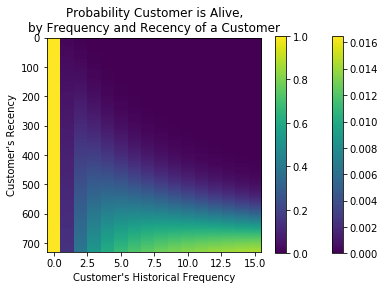

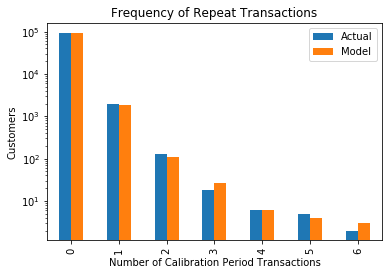

In [3]:
datos_facturacion['date'] = pd.to_datetime(datos_facturacion['order_purchase_timestamp']).dt.date
datos_facturacion = datos_facturacion.drop('order_purchase_timestamp',axis=1)
# se realiza un subconjunto de columnas con los cuales se analizará el comportamiento de compra
transaction_data = datos_facturacion[['customer_id','date','price']]
# se crea el modelo RFM
summary = summary_data_from_transaction_data(transaction_data,'customer_id','date',monetary_value_col='price',)
t=1
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])
plot_frequency_recency_matrix(bgf);
plot_probability_alive_matrix(bgf)
plot_period_transactions(bgf).set_yscale('log');
summary['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, summary['frequency'], summary['recency'], summary['T'])


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


1    95844
2      248
3        4
dtype: int64

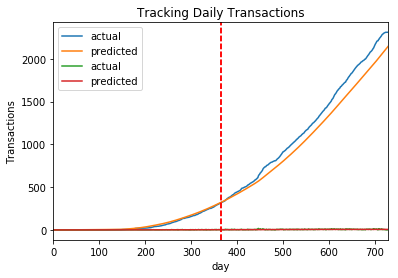

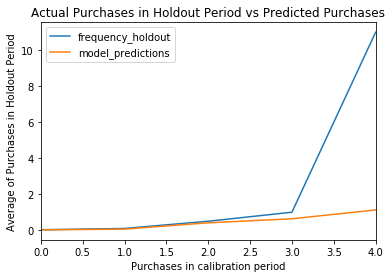

In [4]:
summary_cal_holdout = calibration_and_holdout_data(datos_facturacion, 'customer_id', 'date',calibration_period_end='2017-09-03', observation_period_end='2018-09-03' )
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_cumulative_transactions(bgf, datos_facturacion, 'date', 'customer_id', 730, 365);
plot_incremental_transactions(bgf, datos_facturacion, 'date', 'customer_id', 730, 365);
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout);
datos_clientes.groupby('customer_id').size().value_counts()



churned        1928
high risk        84
not churned      73
Name: churn, dtype: int64

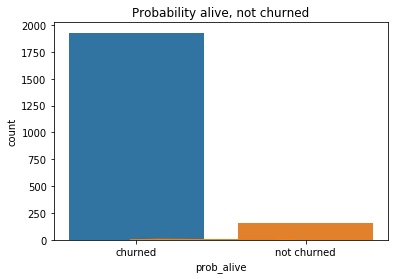

In [5]:
df = summary[summary['frequency']>0]
df['prob_alive'] = bgf.conditional_probability_alive(df['frequency'],df['recency'],df['T'])
sns.distplot(df['prob_alive']);
df['churn'] = ['churned' if p < .1 else 'not churned' for p in df['prob_alive']]
sns.countplot(df['churn']);
sns.distplot(df[df['churn']=='not churned']['prob_alive']).set_title('Probability alive, not churned');
df['churn'][(df['prob_alive']>=.1) & (df['prob_alive']<.2)] = "high risk"
df['churn'].value_counts()


3.2 Churn prediction


In [6]:
print(summary.median())
df['is_churn'] = np.where( (df['frequency']<1) & (df['T']>400) & (df['recency']<1) & (df['recency']<0.000044), 1, 0) 
summary['is_churn'] = np.where( (summary['frequency']<1) & (summary['T']>400) & (summary['recency']<1) & (summary['recency']<0.000044), 1, 0) 
prueba_clientes = pd.merge(datos_clientes,summary[['is_churn']],on='customer_id', how='left')
prueba_clientes = pd.merge(prueba_clientes,datos_facturacion[['customer_id','seller_id']].drop_duplicates(),on='customer_id', how='left')
prueba_clientes['is_churn'].fillna(0, inplace=True)
prueba_clientes['seller_id'].fillna(0, inplace=True)
print(prueba_clientes.count())
prueba_clientes.groupby('is_churn').count()
prueba_clientes['is_churn'].mean()

frequency                0.000000
recency                  0.000000
T                      227.000000
monetary_value           0.000000
predicted_purchases      0.000054
dtype: float64
customer_id                 100232
customer_state              100232
customer_city               100232
customer_zip_code_prefix    100232
is_churn                    100232
seller_id                   100232
dtype: int64


0.17545294915795354

In [0]:
def labelDatase(dataset):

  le = preprocessing.LabelEncoder()

  for column_name in dataset.columns:
        if dataset[column_name].dtype == object:
            dataset[column_name] = le.fit_transform(dataset[column_name])
        else:
            pass

  return dataset
  

In [8]:
print(summary.median())
df['is_churn'] = np.where( (df['frequency']<1) & (df['T']>400) & (df['recency']<1) & (df['recency']<0.000044), 1, 0) 
summary['is_churn'] = np.where( (summary['frequency']<1) & (summary['T']>400) & (summary['recency']<1) & (summary['recency']<0.000044), 1, 0) 

prueba_clientes = pd.merge(datos_clientes,summary[['is_churn']],on='customer_id', how='left')
prueba_clientes = pd.merge(prueba_clientes,datos_facturacion[['customer_id','seller_id']].drop_duplicates(),on='customer_id', how='left')
prueba_clientes['is_churn'].fillna(0, inplace=True)
prueba_clientes['seller_id'].fillna(0, inplace=True)
print(prueba_clientes.count())
prueba_clientes.groupby('is_churn').count()
prueba_clientes['is_churn'].mean()


frequency                0.000000
recency                  0.000000
T                      227.000000
monetary_value           0.000000
predicted_purchases      0.000054
is_churn                 0.000000
dtype: float64
customer_id                 100232
customer_state              100232
customer_city               100232
customer_zip_code_prefix    100232
is_churn                    100232
seller_id                   100232
dtype: int64


0.17545294915795354

In [9]:

enconder = LabelEncoder()


dataset =  prueba_clientes.drop(['customer_city','seller_id'], axis=1)
ds_customer_city = pd.get_dummies(prueba_clientes.customer_city).iloc[:,1:]
#ds_seller_id = pd.get_dummies(prueba_clientes.seller_id.astype('category').cat.codes).iloc[:,1:]
ds_seller_id = pd.get_dummies(prueba_clientes.seller_id).iloc[:,1:]
customer = pd.concat([dataset,ds_customer_city,ds_seller_id], axis=1)
customer['customer_id']= enconder.fit_transform(customer["customer_id"])
customer['customer_state']= enconder.fit_transform(customer["customer_state"])
print(customer.shape)
customer.head()

(100232, 7217)


,customer_id,customer_state,customer_zip_code_prefix,is_churn,abadiania,abaete,abaetetuba,abaiara,abaira,abare,abatia,abdon batista,abelardo luz,abrantes,abre campo,abreu e lima,acaiaca,acailandia,acajutiba,acarau,acari,acegua,acopiara,acreuna,acu,acucena,adamantina,adhemar de barros,adolfo,adrianopolis,adustina,afogados da ingazeira,afonso claudio,afranio,agisse,agrestina,agrolandia,agronomica,agua boa,agua branca,...,fd386aa7bed2af3c7035c65506c9b4a3,fd435faa3c0422b60440ea3480d0e77c,fdaaf5bfda82b7b80535610c831b8d09,fdb9095204a334cd8872252ffec6f2db,fde0cc9ea29c8ccfc0a2c22256a58c71,fdf736c18c589ed030e058312203e1b2,fe19dce63ae80346207c6c55713d1023,fe1b067411b8c5066e962aa146ccee03,fe1bbc5feda5c8979a8a1b3b2512d5a6,fe2032dab1a61af8794248c8196565c9,fe26f3ecb51a15e6d8335cd92da42562,fe49ee029e61e789a1f3a5525f57ba8d,fe4cd9461203cee790d36792420b310f,fe701d88b67eaca109dffd464d1be9f9,fe8055980a4ff7f64ed889c2b5926929,fe87f472055fbcf1d7e691c00b1560dc,fe9d9cf8631285d5982c6e2cf27fb114,feb793c88d836c3a75efa4b5a3465d70,febab0275244b9a49a623f0bd613ca2f,fec6275253471ace26d209bbaa64cd0f,fec6912baad85d41729669edd6b4d3b8,fec8cd45395b3cb0c2b173d7739706a1,fedaedd3ca31d56ab33e92035e4b361c,fedf2c1386e137f296b3bbf3b635e69d,ff063b022a9a0aab91bad2c9088760b7,ff1e15b778c700abdd4d239b81ac466d,ff1fb4c404b2efe68b03350a8dc24122,ff314fa6033cc68ec451c47aee2d6ba4,ff4e2d38692ce827b1a4f4b8196e680d,ff4ea69c2a729e83e63c7579e4ef8170,ff69aa92bb6b1bf9b8b7a51c2ed9cf8b,ff82e8873fba613f2261a9acc896fd84,ffa6adafb71b807dc13159e26431354c,ffad1e7127fb622cb64a900751590acd,ffc470761de7d0232558ba5e786e57b7,ffcfefa19b08742c5d315f2791395ee5,ffdd9f82b9a447f6f8d4b91554cc7dd3,ffeee66ac5d5a62fe688b9d26f83f534,fffd5413c0700ac820c7069d66d98c89,ffff564a4f9085cd26170f4732393726
0,0,25,7787,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,25,6053,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,23,88115,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,13,66812,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,25,18040,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
print(customer.shape)
# se obtiene X y Y , además los datasets de entrenamiento y pruebas
features = customer.drop(['is_churn'], axis=1)
labels = customer['is_churn']
print(features.shape)
print(labels.shape)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=1)

(100232, 7217)
(100232, 7216)
(100232,)


## Random Forest Classifier

In [11]:
# Algoritmo
rfc_object = rfc(n_estimators=200, random_state=0)
rfc_object.fit(train_features, train_labels)
predicted_labels = rfc_object.predict(test_features)
# se verifican resultados
print(classification_report(test_labels, predicted_labels))
print(confusion_matrix(test_labels, predicted_labels))
print(accuracy_score(test_labels, predicted_labels))

              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90     16493
         1.0       0.50      0.30      0.38      3554

    accuracy                           0.82     20047
   macro avg       0.68      0.62      0.64     20047
weighted avg       0.80      0.82      0.80     20047

[[15450  1043]
 [ 2490  1064]]
0.8237641542375418


In [0]:
fi = rf_feat_importance(rfc_object,train_features); fi[10]

## SVM

In [0]:
# Algoritmo
svc_object = svc(kernel='rbf', degree=8)
svc_object.fit(train_features, train_labels)
predicted_labels = svc_object.predict(test_features) 
# se verifican resultados
print(classification_report(test_labels, predicted_labels))
print(confusion_matrix(test_labels, predicted_labels))
print(accuracy_score(test_labels, predicted_labels))

### Regresión Logistica

In [0]:
# Algoritmo
lr_object = LogisticRegression()
lr_object.fit(train_features, train_labels)
predicted_labels = lr_object.predict(test_features)
# se verifican resultados
print(classification_report(test_labels, predicted_labels))
print(confusion_matrix(test_labels, predicted_labels))
print(accuracy_score(test_labels, predicted_labels))

### Arboles de decisión


In [0]:
from sklearn import tree
import graphviz 
# Create each decision tree (pruned and unpruned)
decisionTree_unpruned = tree.DecisionTreeClassifier()
decisionTree = tree.DecisionTreeClassifier(max_depth = 4)
 
# Fit each tree to our training data
decisionTree_unpruned = decisionTree_unpruned.fit(X=train_features, y=train_labels)
decisionTree = decisionTree.fit(X=train_features, y=train_labels)
 
# Generate PDF visual of decision tree
churnTree = tree.export_graphviz(decisionTree, out_file=None, 
                         feature_names = list(train_features.columns.values),  
                         class_names = ['No churn', 'Churn'],
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(churnTree)
graph.render('decision_tree.gv', view=True)
predicted_labels = decisionTree.predict(test_features)
# se verifican resultados
print(classification_report(test_labels, predicted_labels))
print(confusion_matrix(test_labels, predicted_labels))
print(accuracy_score(test_labels, predicted_labels))


### Gradient Boosting Classifier


In [0]:
from sklearn.ensemble import GradientBoostingClassifier

#Create Gradient Boosting Classifier
gb = GradientBoostingClassifier()
#Train the model using the training sets
gb.fit(train_features, train_labels)
#Predict the response for test dataset
predicted_labels = gb.predict(test_features)


# Model Accuracy, how often is the classifier correct?
#print("Accuracy:",metrics.accuracy_score(test_labels, y_pred))
# Model Precision
#print("Precision:",metrics.precision_score(test_labels, y_pred))
# Model Recall
#print("Recall:",metrics.recall_score(test_labels, y_pred))


print(classification_report(test_labels, predicted_labels))
print(confusion_matrix(test_labels, predicted_labels))
print(accuracy_score(test_labels, predicted_labels))

### Deep Learning

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
# Se genera el modelo 
modelo = Sequential()

#Se define un monitor de parada temprana para que el modelo deje de entrenar cuando ya no mejore
early_stopping_monitor = EarlyStopping(patience=3)

#Se obtienen las columnas de entrenamiento

X_dataset = customer.drop (columns= ['customer_id','is_churn'])
Y_dataset = to_categorical (customer.is_churn)
n_cols = X_dataset.shape[1]

#Se agregan las capas, aumentar el número de nodos en cada capa aumenta la capacidad del modelo pero por Collab lo dejare en esa cantidad
# La función de activación que utilizaremos es ReLU o activación lineal rectificada. 
# Aunque se trata de dos piezas lineales, se ha demostrado que funciona bien en redes neuronales.

modelo.add (Dense (128, activation = 'relu', input_shape = (n_cols,))) 
modelo.add( Dropout(0.3))
modelo.add (Dense (64, activation = 'relu')) 
modelo.add( Dropout(0.25))
modelo.add (Dense (64, activation = 'relu')) 
modelo.add( Dropout(0.4))
modelo.add (Dense (64, activation = 'relu')) 
modelo.add( Dropout(0.25))
modelo.add (Dense (2, activation = 'sigmoid')) 

#modelo.add(layers.Flatten())
#Una función de activación permite a los modelos tener en cuenta las relaciones no lineales. 
#Por ejemplo, si predice la diabetes en los pacientes, pasar de los 10 a los 11 años es diferente a los de los 60 a los 61 años.
#La activación es 'softmax'. Softmax hace que la sum
  # compilar el modelo utilizando la precisión para medir el rendimiento del modelo 
modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
resultado=modelo.fit(X_dataset, Y_dataset, batch_size=10, epochs=100, validation_split=0.4, callbacks=[early_stopping_monitor])
#guardarResultado(resultado,'PROPIA2_EXP1')

In [0]:
 prediction[:,0]

## Matriz de correlación

In [0]:
#corr =  customer.drop(['customer_id','is_churn'], axis=1).corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot = True, annot_kws={'size':12})
heat_map=plt.gcf()
heat_map.set_size_inches(20,15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()
 prediction[:,0]

3.2 Churn prediction